In [39]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading

In [40]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [41]:
path = os.path.join(DATA_DIR, 'split_data')
#loading
train_features = pd.read_pickle(os.path.join(path, 'train_features_sensor.pkl'))
test_features = pd.read_pickle(os.path.join(path, 'test_features_sensor_classification.pkl'))
train_labels = pd.read_pickle(os.path.join(path, 'train_labels_classification.pkl'))
test_labels = pd.read_pickle(os.path.join(path, 'test_labels_classification.pkl'))

train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

## FEATURE EXTRACTION WITH PCA

In [44]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

In [45]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 4305) (481, 4305)


In [46]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 234) (481, 234)


In [47]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

### Metrics

In [48]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
#         average_precision[i] = auc(recall[i], precision[i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
#         average_precision[i] = auc(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
#     average_precision["micro"] = auc(recall["micro"], precision["micro"])
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

#     average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["micro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#     roc_auc["macro"] = np.average(list(roc_auc.values()))
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["micro"]

In [49]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## Models

In [50]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [51]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [52]:
# specify runs here
n = 10

### Random Baseline

#### mit shuffling

In [53]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

#### dummy classifiers

%%capture

from sklearn.dummy import DummyClassifier

n=10
strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


### Multi Output Classifier

In [54]:
%%capture

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, forest]

number_of_bootstraps = 10
seed_value = 7

for model in models:
    
    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MOC-'+str(model))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'MOC-'+str(model))

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

In [55]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))
accuracy_scores

0.1185031185031185 0.24719334719334718 1.4091245738045737 0.6274438425463258 0.2730387587671501 0.3804270634432686 0.5010267087201188 0.71291811009833 0.01681294521343512 0.008869173700169625 0.03466098369277329 0.018677258160357108 0.009875922299245516 0.011931662260822847 0.012403040631209429 0.008179187028678526


[0.040332640332640335, 0.09646569646569647, 0.1185031185031185]

## MLP SIMPLE

In [56]:
%%capture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-1L')

    
    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP-1L')

## MLP complex

In [57]:
%%capture


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP')

### Binary Relevance
ignores the possible correlations between class labels

In [58]:
%%capture

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB


a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = BinaryRelevance(GaussianNB())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)


    predicted_labels_br = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_br.toarray())
    
    pr = plot_pr_curve(resampled_ytest, predicted_labels_br.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_br.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'BinaryRelevance')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'BinaryRelevance')

### Classfier Chains

In [59]:
%%capture



from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = ClassifierChain(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_cc = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_cc.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_cc.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_cc.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'ClassifierChains')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'ClassifierChains')

### Label Powerset
takes correlations into account!

In [60]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-LogReg')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-LogReg')

In [61]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-RandFor')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-RandFor')

In [62]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))

0.11621621621621622 0.24376299376299376 1.3827658004158006 0.6227821888848569 0.2813270142180095 0.38756612292189757 0.4990252465255701 0.7177890223188303 0.0034098169369764504 0.0014700764681632994 0.005706445213394674 0.006499148834410289 0.0028999163110480257 0.0035070634242301874 0.00811897645804232 0.0032895414084117194


### Visualisation

In [63]:
%matplotlib inline

[0.040332640332640335, 0.09646569646569647, 0.1185031185031185, 0.05488565488565489, 0.04906444906444907, 0.037214137214137216, 0.09896049896049897, 0.06632016632016632, 0.11621621621621622] [(0.033264033264033266, 0.05332640332640332), (0.07993762993762996, 0.10925155925155926), (0.09365904365904368, 0.14043659043659046), (0.030145530145530147, 0.07567567567567565), (0.031912681912681914, 0.07266112266112265), (0.02338877338877339, 0.05010395010395011), (0.08295218295218296, 0.11663201663201664), (0.049272349272349275, 0.07806652806652807), (0.10997920997920999, 0.11964656964656965)]


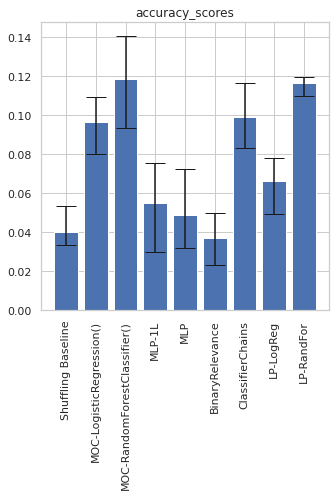

[0.345010395010395, 0.26689189189189183, 0.24719334719334718, 0.30602910602910605, 0.3188929313929314, 0.32099792099792096, 0.267047817047817, 0.2752858627858628, 0.24376299376299376] [(0.33586278586278584, 0.35202702702702704), (0.25856288981288983, 0.2776377338877339), (0.2367593555093555, 0.26199324324324325), (0.29202182952182953, 0.3173336798336798), (0.30689968814968815, 0.33687629937629937), (0.31418918918918926, 0.3305873180873181), (0.25943347193347194, 0.2743633056133056), (0.2680613305613306, 0.2849532224532224), (0.2421777546777547, 0.2461018711018711)]


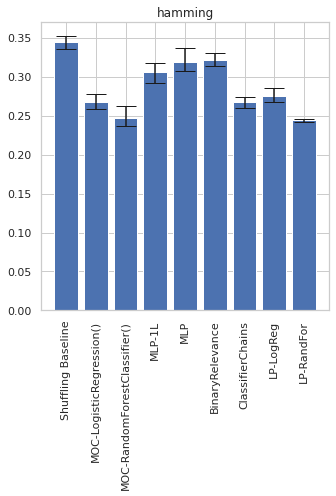

[2.76008316008316, 1.515772904030795, 1.4091245738045737, 1.9962631503305985, 2.2459930238054397, 1.8497266157021481, 1.5524865957063994, 1.5319303683647534, 1.3827658004158006] [(2.6869022869022867, 2.8162162162162163), (1.4581454023679639, 1.567721902008247), (1.3648899792099796, 1.4625023908523906), (1.9185632661201453, 2.0623952853246283), (2.158059225709303, 2.3462645270687155), (1.8046523312337008, 1.904670601733859), (1.4913270227977917, 1.6065505930116641), (1.4902759144739042, 1.592366130005433), (1.3759490124740126, 1.3915363617463619)]


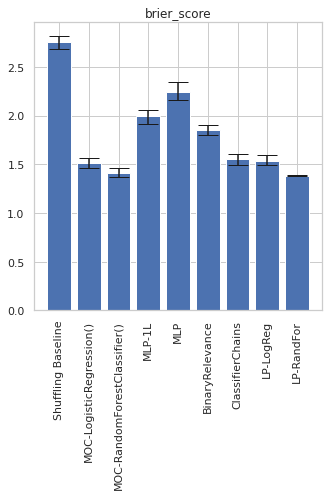

[0.3708056872037915, 0.5332692789760018, 0.6274438425463258, 0.43946289365354607, 0.4162527675073867, 0.3992585663370159, 0.534106892999682, 0.5091817124162963, 0.6227821888848569] [(0.3580094786729858, 0.38748815165876777), (0.5164757232129407, 0.5598765432098765), (0.6009043203352602, 0.6584479343520091), (0.4134800209692452, 0.4622733364869126), (0.38658238250864824, 0.4417277486910995), (0.37102909613059254, 0.4298733242111095), (0.5180977503276095, 0.5572058359056297), (0.48225806451612907, 0.5352860687440706), (0.6117785741229724, 0.6293326622872077)]


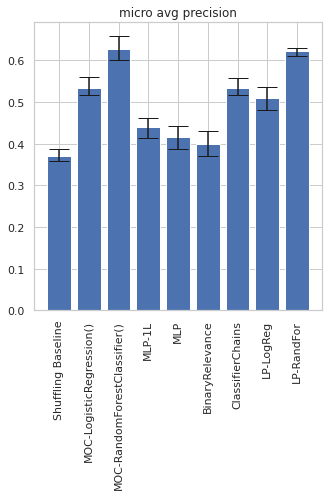

[0.3708056872037915, 0.3193381546146835, 0.2730387587671501, 0.3646842376220775, 0.36493426715767746, 0.3066643851083757, 0.3090737454831858, 0.2683739169128926, 0.2813270142180095] [(0.3580094786729858, 0.38748815165876777), (0.29558849803470044, 0.34028449565864105), (0.25801525220398597, 0.2859429486080146), (0.33405080743700677, 0.40158686676971844), (0.3241873267741659, 0.39718172983479105), (0.28600382430558663, 0.3325111469380558), (0.2890480869760855, 0.32905479414729844), (0.2472671501715275, 0.28410862957578964), (0.2781516587677725, 0.2864454976303317)]


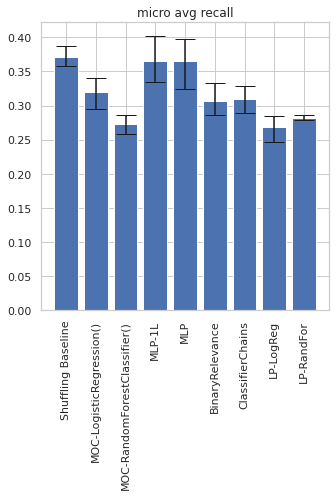

[0.3708056872037915, 0.39921026820295535, 0.3804270634432686, 0.3981685998262515, 0.3884542684458351, 0.3466551439983882, 0.39127350292129826, 0.35130217141023634, 0.38756612292189757] [(0.3580094786729858, 0.38748815165876777), (0.37896966819823336, 0.4178515873007971), (0.36179035035672424, 0.395426812319324), (0.3763534218590398, 0.4232779435734334), (0.3628533627044104, 0.4167116901925976), (0.32670240509997106, 0.3744496143122268), (0.37438301606588364, 0.405631359685091), (0.32881896210549955, 0.3670102778753324), (0.38339269691828154, 0.39340919523567924)]


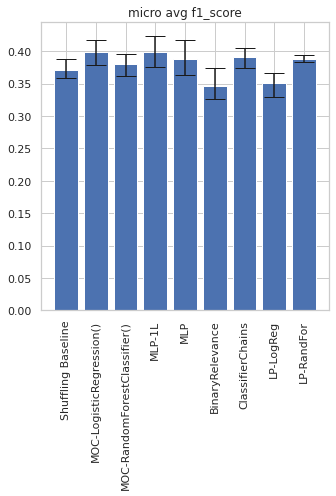

[0.3101118101149772, 0.46576738740322055, 0.5010267087201188, 0.41694789594065707, 0.3862499022624447, 0.3816436127204555, 0.45068889925134636, 0.45070452799285193, 0.4990252465255701] [(0.3041923055442406, 0.3181353865523808), (0.4509042734701112, 0.4773997351026763), (0.48703375047501374, 0.5215242553763232), (0.39660050387496504, 0.4363666805347799), (0.3569843019670269, 0.4048821921217841), (0.3601939085835533, 0.39932766644284023), (0.4377534890298109, 0.46392877293830725), (0.4358820259788684, 0.4688159437543554), (0.4892092240454645, 0.5129964424487965)]


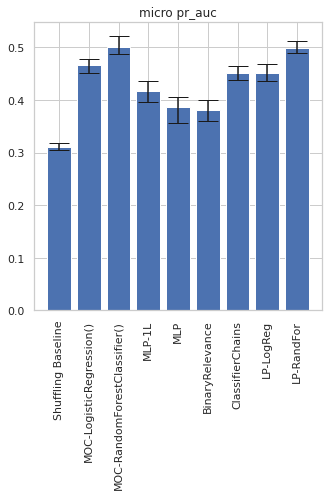

[0.5665700473254904, 0.6971412691067246, 0.71291811009833, 0.6529722810556503, 0.6182954104188291, 0.6591046322966665, 0.6877620921941162, 0.6895487477356729, 0.7177890223188303] [(0.557755186883933, 0.5780620135307803), (0.6868838687994742, 0.7095767346993881), (0.7000431932338355, 0.7230422987475711), (0.6409685259628513, 0.6687805768201784), (0.5921416862465865, 0.6415790863832601), (0.6484728082636417, 0.6704104758683984), (0.6758348921329282, 0.7025507384302767), (0.6817821311378007, 0.696625410479548), (0.7118778072466203, 0.7205333238309044)]


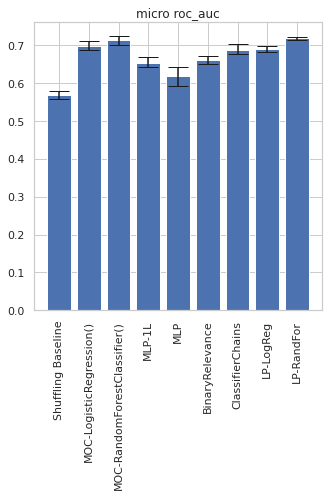

In [64]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()

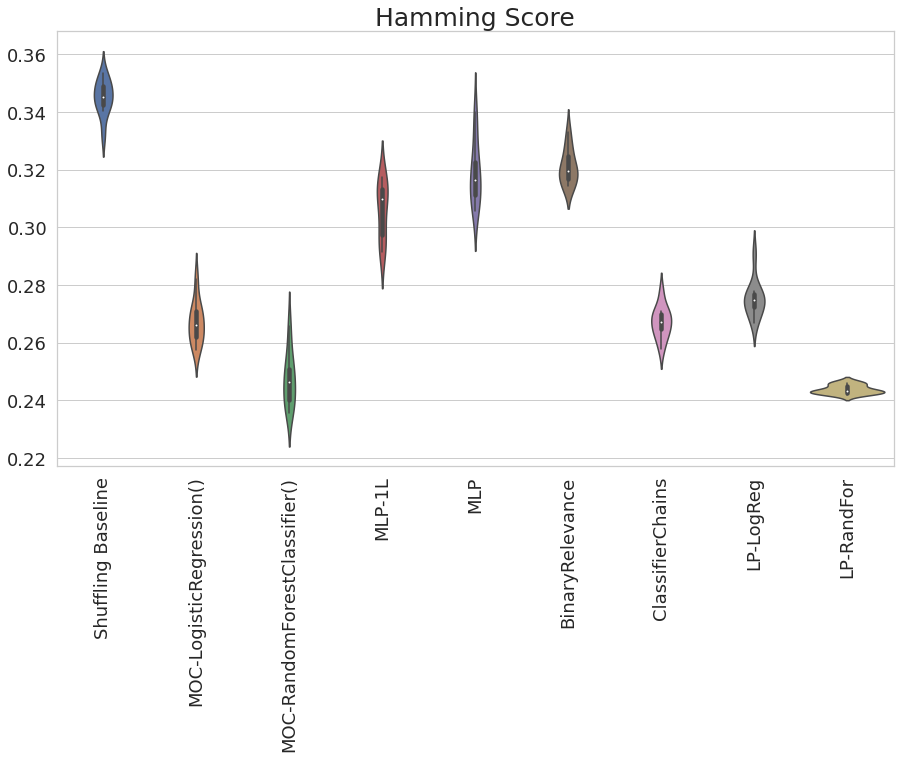

In [69]:
import seaborn as sns
#sns.set(style="whitegrid")

# plot
sns.violinplot(y=hamming_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Hamming Score", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


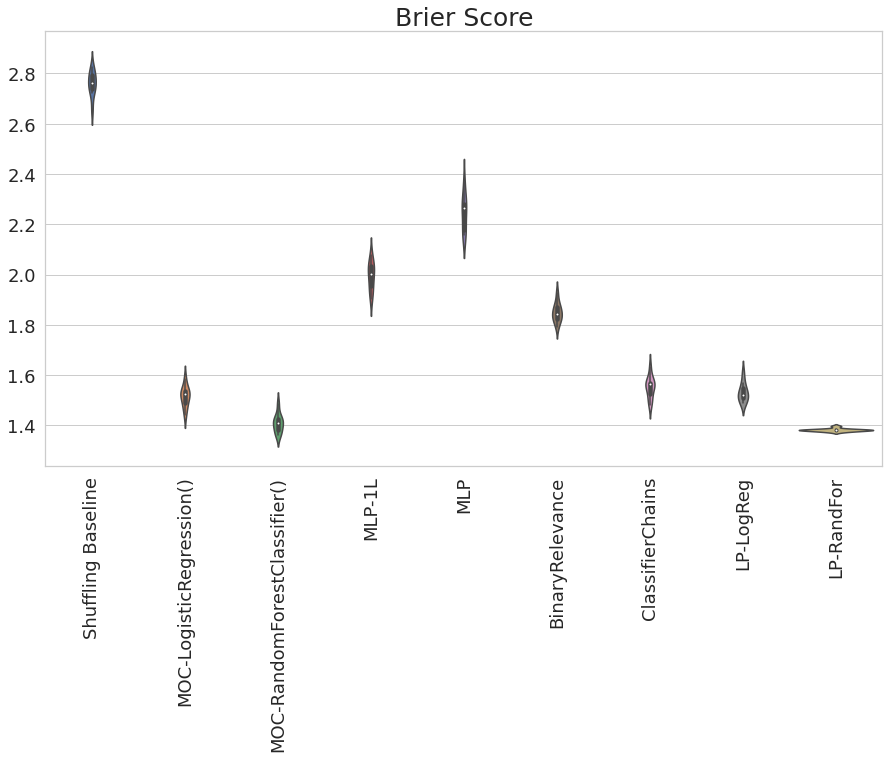

In [66]:

# plot
sns.violinplot(y=brier_score_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Brier Score", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


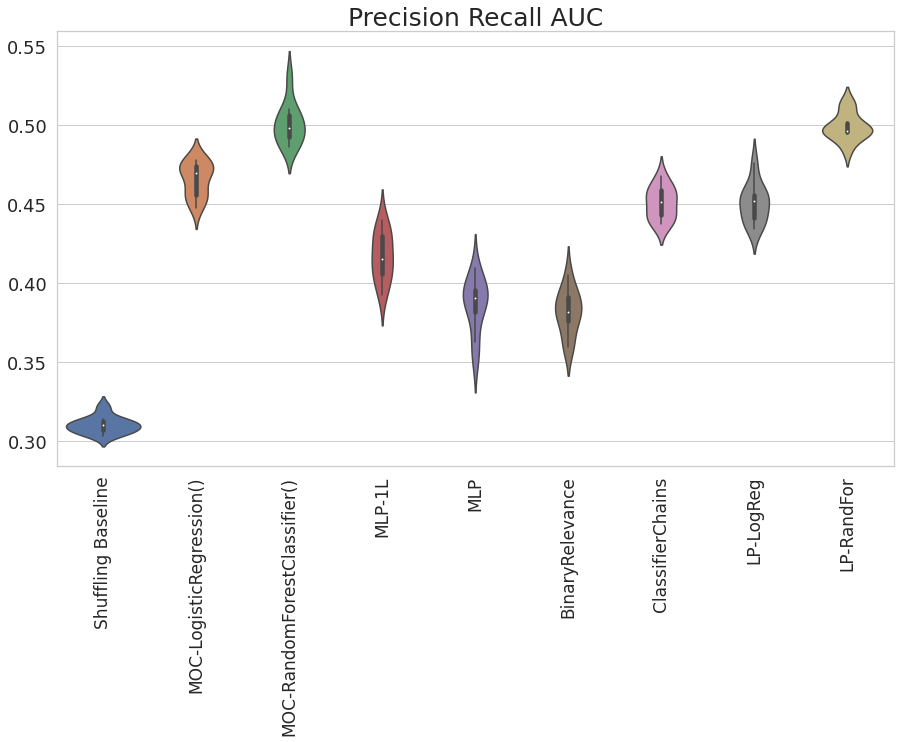

In [67]:

# plot
sns.violinplot(y=pr_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Precision Recall AUC", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=17)
plt.yticks(fontsize=18)
plt.show()


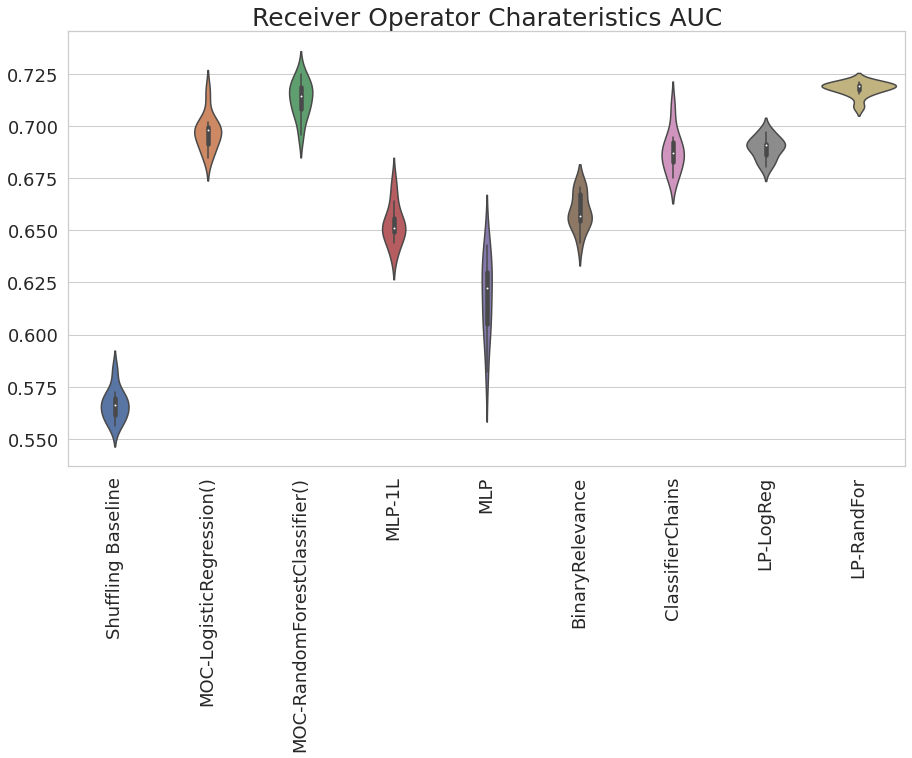

In [68]:

# plot
import seaborn as sns

sns.violinplot(y=roc_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Receiver Operator Charateristics AUC", fontsize = 25)
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()